# Исследовательский проект по НИС «Анализ данных в Python»
<div style="text-align: right">
    Проект подготовлен студентами БПИ228
    <br>
    Лысиным Кириллом и Гакал Анжеликой
</div>

## Часть 2. Сбор данных из интернета и составление датасета.
Данную часть задания мы выполняли первой, так как её результаты являются предметом аналаза в следующей части задания.

После обсуждения вариантов мы решили собирать информацию о товарах и услугах, размещённых на сервисе объявлений Юла.
Выбором данного сервиса объявлений обусловлен ряд решений в области реализации:
<br>
<p style="margin-left: 50px;">
    <ul>
        <li>Библиотека requests, пройденная на занятиях, не позволяет получить все необходимые данные со страницы, так как часть контента отображается только после выполнения js-скриптов, что не происходит при использовании вышеуказанной библиотеки, поэтому для получения данных с сайта исопльзуется библиотека selenium.</li>
        <li>Работа с динамически генерируемым содержимым сайта делает невозможной (или крайне затруднительной) унификацию процесса, так как для разных устройств это содержимое может отличаться. Этим фактом обусловлена заточенность прогаммы, осуществляющей парсинг, под конкретное устройство, но изменения, необходимые для работы программы на другом устройстве могут быть внесены за незначительный промежуток времени.</li>
    </ul>
</p>

In [2]:
import datetime
from selenium import webdriver
import pandas as pd
import time
from bs4 import BeautifulSoup
import os.path


    
driver = webdriver.Chrome()

with open('visited_links.txt', 'w+') as f:
    visited_links = set(f.readlines())


def get_item_info(url):
    
    info_dict = {}
    soup = get_soup(url)
    if(soup == None):
        return
    
    general_info = str(soup.findAll('meta', {'property':"og:description"})[0])

    # Сохранение данных о товаре/услуге в словарь
    info_dict['Name'] = get_item_name(general_info)
    info_dict['Price (in rubles)'] = get_item_price(general_info)
    info_dict['Category'] = get_item_category(general_info)
    info_dict['Region'] = get_item_region(soup)
    info_dict['Time/date of placement'] = get_item_placement_time(soup)
    info_dict['Added to favourites'] = get_favourites(soup)
    info_dict['Number of seller\'s ads'] = get_number_of_ads(soup)
    info_dict['Seller rating'] = get_seller_rating(soup)
    info_dict['Number of views'] = get_number_of_views(soup)
    info_dict['Number of images'] = get_number_of_images(soup)
    info_dict['Link'] = url
    
    return info_dict

def get_soup(url, counter = 0):

    time.sleep(1)
    try:
        driver.get(url)
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        return soup
    # Если не удалось сразу получить страницу, то программа пробует еще несколько раз
    except:
        if(counter < 3):
            return get_soup(url, counter + 1)
    # Если после несольких попыток так и не удалось считать содержимое страницы, то этот метод вернет None

def get_item_name(info):
    try:
        name = info[15:info.find('–') - 1]
        return name
    except:
        return None

def get_item_price(info):
    try:
        if not('Цена: ' in info):
            return 0
        price = float(info[info.find('Цена: ') + 6:info.find('руб.') - 1].replace(' ', ''))
        return price
    except:
        return 0

def get_item_category(info):
    try:
        category = info[info.find('раздела «') + 9:info.find('».')]
        return category
    except:
        return None

def get_item_region(soup):
    try:
        region = list(soup.findAll('span', class_='sc-cOxWqc hNYaaO'))[0].text
        return region
    except:
        return None

def get_item_placement_time(soup):
    try:
        s = list(soup.findAll('dd', class_='sc-cOxWqc sc-fVmuvm eOPaPs dVayGV'))[-1].text
        now = datetime.datetime.now()
        if('Сегодня в' in s):
            return datetime.datetime(now.year, now.month, now.day, int(s[-5:-3]), int(s[-2:]))
        if('Вчера в' in s):
            return (datetime.datetime(now.year, now.month, now.day, int(s[-5:-3]), int(s[-2:])) + datetime.timedelta(days=-1))
        if('Позавчера в' in s):
            return (datetime.datetime(now.year, now.month, now.day, int(s[-5:-3]), int(s[-2:])) + datetime.timedelta(days=-2))


        months = ['янв', 'фев', 'мар', 'апр', 'мая', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']
        for j in range(len(months)):
            if(months[j].lower() in s):
                return datetime.datetime(now.year, j + 1, int(s[:2]), 12)
        return datetime.datetime(day=int(s[:2]), month=int(s[3:5]), year=int(s[6:10]), hour = 12)
    except:
        return None


def get_favourites(soup):
    try:
        favourites_count = list(soup.findAll('dd', class_="sc-cOxWqc sc-fVmuvm eOPaPs dVayGV"))
        return int(favourites_count[-3].text)
    except:
        return None

def get_number_of_ads(soup):
    try:
        n = list(soup.findAll('span', {'data-test-component':"UserNameClick"}))[0].text
        n = int(n[n.find('(')+1:n.find(' объявл')])
        return n
    except:
        return None

def get_seller_rating(soup):
    try:
        rating = soup.find('span', class_="sc-cOxWqc eDoIYl")
        return float(rating.text.replace(',', '.')) if rating != None else None
    except:
        return None

def get_number_of_views(soup):
    try:
        number_of_views = list(soup.findAll('dd', class_='sc-cOxWqc sc-fVmuvm eOPaPs dVayGV'))
        return int(number_of_views[-2].text)
    except:
        return None

def get_number_of_images(soup):
    try:
        images = list(soup.findAll('img', class_="sc-fBnnfK"))
        return len(images)
    except:
        return None

def get_links(scroll_count):
    
    url = r'https://youla.ru/'
    driver.get(url)
    time.sleep(1)
    
    for i in range(scroll_count):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")
    
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    links = [str(i.a) for i in soup.findAll('span', class_="sc-llGDqb sc-gqgnwQ fEAASo hZGRky")]
    links = [r'https://youla.ru' + s[s.find(r'href="') + 6 : s.find(r'" rel')] for s in links]
    return links



n = 50
for i in range(n):
    items = []
    print(f"Processing batch {i + 1} out of {n}:", end='')
    links = get_links(1)
    for i in range(len(links)):
        if(int(i * 100/len(links))//5 > int((i - 1) * 100/len(links))//5):
            print(' .', end='')
        link = links[i]
        if(link in visited_links):
            continue
        items.append(get_item_info(link))
        visited_links.add(link)
    print(' ✓')

    df = pd.DataFrame(items)
    if(len(df) > 0):
        df = df.set_index('Name')
        if(os.path.isfile('items.xlsx')):
            prev_df = pd.read_excel('items.xlsx', index_col = 0)
            df = pd.concat([prev_df, df])

        df.to_excel('items.xlsx')

print("Done! The data has been saved to the file items.xlsx")

with open('visited_links.txt', 'a') as f:
    for line in visited_links:
        f.write(f"{line}\n")



driver.quit()
df

Processing batch 1 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 2 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 3 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 4 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 5 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 6 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 7 out of 50: . . . . . . . . . . . . ✓
Processing batch 8 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 9 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 10 out of 50: . . . . . . . . . . . . ✓
Processing batch 11 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 12 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 13 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 14 out of 50: . . . . . . . . . . . . . . . . . . . . ✓
Processing batch 15

,Price (in rubles),Category,Region,Time/date of placement,Added to favourites,Number of seller's ads,Seller rating,Number of views,Number of images,Link
Name,,,,,,,,,,
Брюки 80-92,0.0,Детский гардероб,Москва,2023-01-31 22:00:00,2.0,40.0,5.0,14.0,5,https://youla.ru/moskva/detskaya-odezhda/shtan...
Туфли размер 30. Бесплатно,0.0,Детский гардероб,Химки,2023-01-31 21:59:00,0.0,54.0,5.0,18.0,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...
Кошка бесплатно,0.0,Животные,Москва,2023-01-31 21:59:00,7.0,1.0,NaN,307.0,3,https://youla.ru/all/zhivotnye/koshki/bielaia-...
Demix на 6 лет на синтепоне,0.0,Детский гардероб,Котельники,2023-01-31 21:59:00,0.0,111.0,5.0,127.0,4,https://youla.ru/kotelniki/detskaya-odezhda/ve...
Красивый пёс в добрые руки,0.0,Животные,Люберцы,2023-01-31 21:59:00,151.0,19.0,NaN,8402.0,10,https://youla.ru/lyubertsy/zhivotnye/sobaki/kr...
...,...,...,...,...,...,...,...,...,...,...
Очки без диоптрий,300.0,Красота и здоровье,Москва,2023-02-03 17:17:00,0.0,3.0,5.0,0.0,4,https://youla.ru/moskva/krasota-i-zdorove/medi...
Новое платье паетки,1800.0,Женский гардероб,Москва,2023-02-03 11:01:00,0.0,173.0,5.0,1.0,5,https://youla.ru/moskva/zhenskaya-odezhda/plat...
Люстра 80-е годы,3000.0,Для дома и дачи,Москва,2023-01-27 12:00:00,0.0,6.0,5.0,15.0,3,https://youla.ru/moskva/dom-dacha/osveshchenie...


## Часть 1. Анализ датасета.

Загружаем содержимое файла items.xlsx, в котором содержатся данные, полученные в ходе выполнения части 2 проекта.  
Переименуем некоторые столбцы для удобства и выведем первые 5 строк датафрейма.

In [2]:
import pandas as pd

df = pd.read_excel("items.xlsx")
# Переименуем названия столбцов датасета для более удобного доступа к ним
df = df.rename(
    columns={
        'Time/date of placement': 'Placement_time',
        'Added to favourites': 'Favourites_count',
        'Number of views':'Views',
        'Number of images':'Images',
        'Price (in rubles)':'Price',
        'Number of seller\'s ads':'Ads_count',
        'Seller rating':'Seller_rating'
    })
df.head()


,Name,Price,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link
0,Брюки 80-92,0.0,Детский гардероб,Москва,2023-01-31 22:00:00,2.0,40.0,5.0,14.0,5,https://youla.ru/moskva/detskaya-odezhda/shtan...
1,Туфли размер 30. Бесплатно,0.0,Детский гардероб,Химки,2023-01-31 21:59:00,0.0,54.0,5.0,18.0,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...
2,Кошка бесплатно,0.0,Животные,Москва,2023-01-31 21:59:00,7.0,1.0,NaN,307.0,3,https://youla.ru/all/zhivotnye/koshki/bielaia-...
3,Demix на 6 лет на синтепоне,0.0,Детский гардероб,Котельники,2023-01-31 21:59:00,0.0,111.0,5.0,127.0,4,https://youla.ru/kotelniki/detskaya-odezhda/ve...
4,Красивый пёс в добрые руки,0.0,Животные,Люберцы,2023-01-31 21:59:00,151.0,19.0,NaN,8402.0,10,https://youla.ru/lyubertsy/zhivotnye/sobaki/kr...


### Описание датасета

<i><b>- Определим размер датасета:</b></i>

In [3]:
size = df.shape
print(f"Количество строк (наблюдений): {size[0]}\n"+
     f'Количество столбцов (переменных): {size[1]}')

Количество строк (наблюдений): 10923
Количество столбцов (переменных): 11


<b><i>- Опишем переменные:</b></i>

In [4]:
columns = df.columns.to_list()
column_types = [str(i).ljust(15, ' ') for i in df.dtypes.to_list()]
na_count = [str(i) for i in df.isna().sum()]

s = [str(i) for i in df['Category']]
df['Category'] = s;
print("В датасете содержатся следующие переменные:")
print(*[('\t' + i).ljust(20, ' ') + "|тип данных переменной: " + j + "|число пустых значений: " + k for i, j, k in zip(columns, column_types, na_count)], sep='\n')

В датасете содержатся следующие переменные:
	Name               |тип данных переменной: object         |число пустых значений: 0
	Price              |тип данных переменной: float64        |число пустых значений: 0
	Category           |тип данных переменной: object         |число пустых значений: 0
	Region             |тип данных переменной: object         |число пустых значений: 28
	Placement_time     |тип данных переменной: datetime64[ns] |число пустых значений: 304
	Favourites_count   |тип данных переменной: float64        |число пустых значений: 301
	Ads_count          |тип данных переменной: float64        |число пустых значений: 370
	Seller_rating      |тип данных переменной: float64        |число пустых значений: 4909
	Views              |тип данных переменной: float64        |число пустых значений: 28
	Images             |тип данных переменной: int64          |число пустых значений: 0
	Link               |тип данных переменной: object         |число пустых значений: 0


<p style="margin-left:5em;">
    <ul>
        <li><em>Name</em> - Наименование товара/услуги. Категориальная переменная</li>  
        <li><em>Price</em> - цена товара/услуги в рублях. Метрическая переменная</li>  
        <li><em>Category</em> - категория товара. Категориальная переменная (Номинальная)</li>
        <li><em>Region</em> - местоположение продавца. Категориальная переменная (Номинальная)</li>
        <li><em>Placement_time</em> - дата и время размещения объявления. Метрическая переменная</li> 
        <li><em>Favourites_count</em> - количество людей, добавивших объявление в избранное. Метрическая переменная</li>
        <li><em>Ads_count</em> - количество объявлений, которые разместил продваец на сервисе. Метрическая переменная</li>
        <li><em>Seller_rating</em> - рейтинг продавца по пятибалльной шкале. Категориальная переменная (Порядковая)</li>
        <li><em>Views</em> - количество просмотров объявления. Метрическая переменная</li>
        <li><em>Images</em> - количество фотографий, прикреплённых к объявлению. Метрическая переменная</li>
        <li><em>Link</em> - ссылка на объявление</li>
    </ul>
</p>

<b><i>- Изменение типов данных:</i></b>
<br>Для данного датасета не нужно изменять типы данных в столбцах, так как он был составлен с учётом необходимости дальнейшего анализа.

### Добавление новых столбцов

Добавим новые колонки:
<ul>
    <li><em>Favourites_percent</em>, отражающую процент тех пользователей, которые добавили товар в избранное из числа людей, просмотревших объявление. (Категориальная (порядковая) переменная, тип значений в столбце - float64)</li>
    <li><em>Free_item</em>, показывающую, является ли товар/услуга бесплатной. (Категориальная (бинарная) переменная, тип значений в столбце - bool)</li>
</ul>

In [5]:
favourites_percent = [i/j * 100 if j != 0 else None for i, j in zip(df["Favourites_count"], df["Views"])]
free = [i == 0 for i in df["Price"]]
df['Favourites_percent'] = favourites_percent
df['Free_item'] = free
df.head()

,Name,Price,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link,Favourites_percent,Free_item
0,Брюки 80-92,0.0,Детский гардероб,Москва,2023-01-31 22:00:00,2.0,40.0,5.0,14.0,5,https://youla.ru/moskva/detskaya-odezhda/shtan...,14.285714,True
1,Туфли размер 30. Бесплатно,0.0,Детский гардероб,Химки,2023-01-31 21:59:00,0.0,54.0,5.0,18.0,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...,0.000000,True
2,Кошка бесплатно,0.0,Животные,Москва,2023-01-31 21:59:00,7.0,1.0,NaN,307.0,3,https://youla.ru/all/zhivotnye/koshki/bielaia-...,2.280130,True
3,Demix на 6 лет на синтепоне,0.0,Детский гардероб,Котельники,2023-01-31 21:59:00,0.0,111.0,5.0,127.0,4,https://youla.ru/kotelniki/detskaya-odezhda/ve...,0.000000,True
4,Красивый пёс в добрые руки,0.0,Животные,Люберцы,2023-01-31 21:59:00,151.0,19.0,NaN,8402.0,10,https://youla.ru/lyubertsy/zhivotnye/sobaki/kr...,1.797191,True


<b><em>- Перекодирование переменных</em></b>
<br>
Добавим столбец <em>Price_range</em>, в котором перекодируем метрическую переменную <em>Price</em> в категориальную.
Все цены разделели на 5 категорий:
<ul>
    <li><em>free</em> - бесплатные товары</li>
    <li><em>small price</em> - недорогие товары (стоимостью до 5000 рублей)</li>
    <li><em>affordable</em> - товары среднего ценового сегмента (от 5000 до 15000 рублей)</li>
    <li><em>expensive</em> - дорогие товары (от 15000 до 100000 рублей)</li>
    <li><em>luxury</em> - товары роскоши (стоимостью более 100000 рублей)</li>
</ul>

In [6]:
price_range = ["free" if x == 0 else "small price" if x <= 5000 else "affordable" if x <= 15000 else "expensive" if x <= 100000 else "luxury" for x in df['Price']]
df.insert(2, 'Price_range', price_range)

In [7]:
df.head(10)

,Name,Price,Price_range,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link,Favourites_percent,Free_item
0,Брюки 80-92,0.0,free,Детский гардероб,Москва,2023-01-31 22:00:00,2.0,40.0,5.0,14.0,5,https://youla.ru/moskva/detskaya-odezhda/shtan...,14.285714,True
1,Туфли размер 30. Бесплатно,0.0,free,Детский гардероб,Химки,2023-01-31 21:59:00,0.0,54.0,5.0,18.0,0,https://youla.ru/himki/detskaya-odezhda/obuv/t...,0.000000,True
2,Кошка бесплатно,0.0,free,Животные,Москва,2023-01-31 21:59:00,7.0,1.0,NaN,307.0,3,https://youla.ru/all/zhivotnye/koshki/bielaia-...,2.280130,True
3,Demix на 6 лет на синтепоне,0.0,free,Детский гардероб,Котельники,2023-01-31 21:59:00,0.0,111.0,5.0,127.0,4,https://youla.ru/kotelniki/detskaya-odezhda/ve...,0.000000,True
4,Красивый пёс в добрые руки,0.0,free,Животные,Люберцы,2023-01-31 21:59:00,151.0,19.0,NaN,8402.0,10,https://youla.ru/lyubertsy/zhivotnye/sobaki/kr...,1.797191,True
5,!Зимний конверт на выписку.,0.0,free,Детский гардероб,Апрелевка,2023-01-31 21:59:00,7.0,4.0,5.0,499.0,3,https://youla.ru/aprelevka/detskaya-odezhda/ko...,1.402806,True
6,Диски для гантелей,150.0,small price,Спорт и отдых,Москва,2023-01-31 14:51:00,0.0,607.0,5.0,3.0,3,https://youla.ru/moskva/sport-otdyh/trenazhery...,0.000000,False
7,6 16 коробка,100000.0,expensive,Легковые автомобили,Москва,2023-01-31 17:22:00,1.0,1.0,NaN,13.0,6,https://youla.ru/moskva/auto/s-probegom/6-16-k...,7.692308,False
8,"Подушки Бамбук новые, в упаковках",450.0,small price,Для дома и дачи,Москва,2023-01-31 12:58:00,160.0,9.0,NaN,3060.0,0,https://youla.ru/moskva/dom-dacha/tekstil-kovr...,5.228758,False
9,Щенки той пуделя Ркф -FCI,0.0,free,Животные,Москва,2023-01-28 12:00:00,11.0,1.0,NaN,476.0,5,https://youla.ru/moskva/zhivotnye/sobaki/shchi...,2.310924,True


<b><em>- Формирование среза таблицы и его транспонирование</em></b>

Выберем случайные 15 подряд идущих строк из датафрейма и транспонируем их.

In [8]:
import random as rand
k = rand.randint(0, size[0] - 15)
df.loc[k:k+15, :].T

,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
Name,"Hyundai H-1, 2008",Кроссовки Nike Air Jordan 4 Cool Grey (36-45),Джинсы,Трос акпп Ford Focus 3 (2011-2015) ХЭТЧБЕК 1.6,Кроссовки nike air jordan 4 retro,Парка-Куртка Fred Perry,"Mitsubishi Outlander, 2012",Мужской подарочный набор,Сухой корм для собак TITBIT.гипоалергенный пре...,Ява двигатель,"Кроссовки Adidas, размер 41 российский, 42 евр...",Шапка Еа7,Кокер спаниель щенки,"Toyota RAV4, 2015",Холодильник,Удилище кастинговое Sportex Black Pearl GT-3
Price,727200.0,5790.0,500.0,3000.0,4999.0,6500.0,628800.0,2000.0,100.0,40.0,1100.0,2500.0,13000.0,1673000.0,5000.0,6000.0
Price_range,luxury,affordable,small price,small price,small price,affordable,luxury,small price,small price,small price,small price,small price,affordable,luxury,small price,affordable
Category,Легковые автомобили,Мужской гардероб,Детский гардероб,Запчасти и автотовары,Мужской гардероб,Мужской гардероб,Легковые автомобили,Мужской гардероб,Животные,Спецтехника и мотоциклы,Мужской гардероб,Мужской гардероб,Животные,Легковые автомобили,Бытовая техника,Спорт и отдых
Region,Москва,Москва,Москва,"Москва, Дорожная улица, 60Ас1",Москва,Москва,Москва,Москва,Москва,Москва,Москва,Москва,Москва,Москва,Москва,Москва
Placement_time,2023-02-02 16:25:00,2023-02-02 21:40:00,2023-02-02 10:46:00,2023-02-02 07:19:00,2023-01-27 12:00:00,2023-02-02 21:27:00,2023-01-13 12:00:00,2023-02-01 14:06:00,2023-01-20 12:00:00,2023-01-11 12:00:00,2023-01-10 12:00:00,2023-01-31 13:42:00,2023-01-23 12:00:00,2023-02-02 16:24:00,2023-01-26 12:00:00,2023-01-31 01:08:00
Favourites_count,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,11.0,10.0,5.0,0.0,11.0,0.0,7.0,0.0
Ads_count,187.0,749.0,255.0,1650.0,1271.0,7.0,185.0,426.0,2.0,3.0,28.0,84.0,3.0,221.0,18.0,2.0
Seller_rating,NaN,5.0,5.0,NaN,5.0,NaN,NaN,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
Views,2.0,89.0,0.0,22.0,15.0,6.0,47.0,8.0,132.0,480.0,152.0,1.0,154.0,4.0,310.0,6.0


<b><em> - Многоуровневая сортировка</em></b>

Отсортируем датафрейм сначала по убыванию цены, а затем по убыванию количества просмотров. После этого выведем первые 20 наблюдений из отсортированного датасета.

In [9]:
sortedDf = df.dropna(subset = ['Price', 'Views']).sort_values(['Price', 'Views'], ascending=[False, False])
sortedDf.iloc[:20, :][['Price', 'Views']]

,Price,Views
7406,74900000.0,65.0
6649,40000000.0,2228.0
2320,40000000.0,2211.0
570,40000000.0,2184.0
9316,15000000.0,6041.0
5734,15000000.0,6038.0
5257,15000000.0,6036.0
7371,12000000.0,652.0
3546,12000000.0,648.0
2894,12000000.0,632.0


### Цель и задачи исследования

<b>Цель исследования:</b> проанализировать заинтересованность покупателей в товарах выбранных категорий, а также перспективы продавцов при реализации товаров в этих категориях.
<br><br>
<b>Задачи исследования:</b>
<ol>
    <li>Сформировать исследовательские гипотезы</li>
    <li>Построить графики, отражающие зависимость между выбранными переменными датасета</li>
    <li>Проанализировать данные, полученные на предыдущих этапах исследования</li>
    <li>Подтвердить или опровергнуть поставленные гипотезы</li>
</ol>

### Формирование исследовательских гипотез

<b>H1. </b>Рейтинг продавца зависит от количества размещённых объявлений<br>
<b>H2. </b>Объявления категории "Телефоны и планшеты" представлены наиболее широко - данная категория товаров является высоко конкурентной<br>
<b>H3. </b>Товары, относящиеся к предметам роскоши, составляют наибольший процент от всех товаров в Москве<br>


<b>H4. </b>Отношение услуг к товарам меньше 20%<br>
<b>H5. </b>Количество людей, добавивших товар в избранное, увеличивается с уменьшением цены.<br>
<b>H6. </b>Чем больше фотографий представлено в объявлении, тем больше процент людей, добавивших товар в избранное, из числа просмотревших<br>
<b>H7. </b>Количество людей, добавивших товар в избранное, зависит от рейтинга продавца.<br>
<b>H8. </b>Средняя на товары из категорий "Недвижимость", "Легковые автомобили", "Бытовыая техника", "Одежда" в Москве выше средней цены в других регионах<br> 
<b>H9. </b>На выходных активность продавцов на сайте выше<br>
<b>H10. </b>Заинтересованность покупателей в бесплатных товарах в выбранных категориях выше, чем в платных.<br>

### Проверка гипотез

<h4><b>H1. </b>Рейтинг продавца зависит от количества размещённых объявлений</h4>
Сначала исключим те строки, данные о рейтинге в которых пропущены.

In [10]:
ratingDf = df.dropna(subset = ['Seller_rating'])

Посчитаем значение корреляции между рейтингом продавца и количеством объявлений.

0.01868


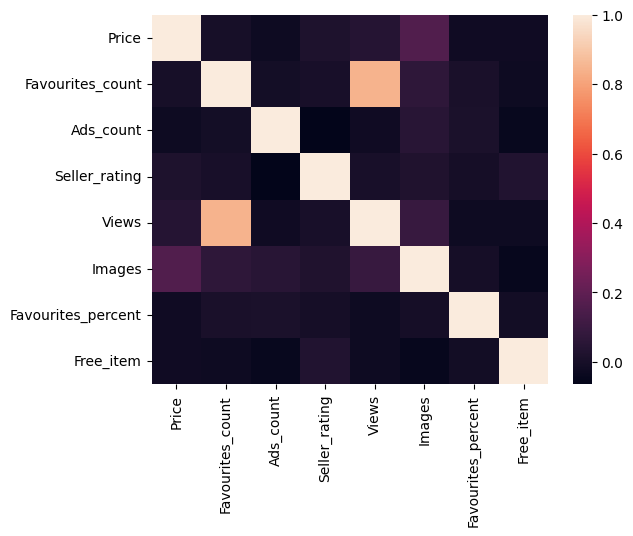

In [42]:
import seaborn as sns
sns.heatmap(ratingDf.corr(numeric_only = True))
print(f"{ratingDf['Seller_rating'].corr(ratingDf['Price']):.5f}")

Корреляция отсутствует - <i>гипотеза не подтвердилась.</i> 

<h4><b>H2. </b>Объявления категории "Телефоны и планшеты" представлены наиболее широко - данная категория товаров является высоко конкурентной</h4>
Посчитаем количество товаров и услуг в каждой категории.

Category
Легковые автомобили             1849
Для дома и дачи                 1269
Телефоны и планшеты             1138
Женский гардероб                1135
Животные                         796
Детские товары                   618
Стройматериалы и инструменты     564
Мужской гардероб                 430
Детский гардероб                 429
Красота и здоровье               404
Хобби и развлечения              367
Спорт и отдых                    352
Бытовая техника                  346
Компьютерная техника             303
ТВ, аудио, видео                 272
Услуги исполнителей              216
Хэндмейд                         152
Спецтехника и мотоциклы           99
Недвижимость                      70
Запчасти и автотовары             60
Фото- и видеокамеры               44
Для бизнеса                        6
Вакансии                           4
dtype: int64

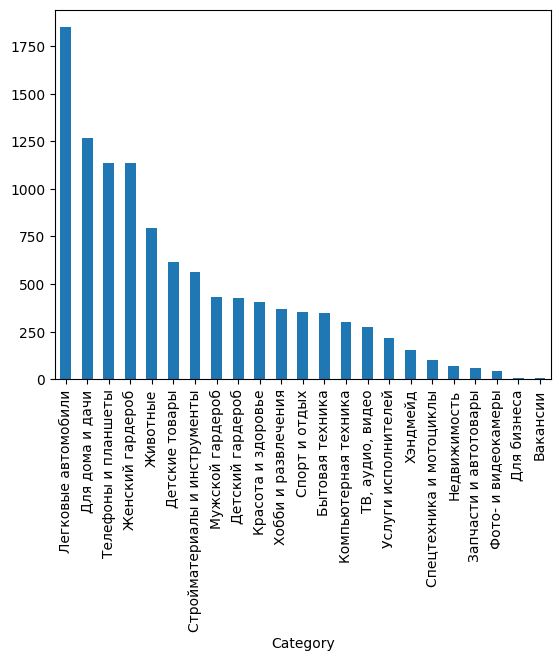

In [12]:
import matplotlib.pyplot as plt
category_counts = df.value_counts("Category")
category_counts.plot(kind="bar")
category_counts

<i>Гипотеза не подтвердилась.</i><br>
Категория "Телефоны и планшеты" находится лишь на третьем месте по количеству объявлений (1138 объявлений), её превосходят категории "Для дома и дачи" (1269 объявлений) и "Легковые автомобили" (1849 объявлений). Все 3 упомянутых категории товаров высоко конкуретны, это значит, что большие перспективы откроются продавцам в других категориях.


<h4><b>H3. </b>Товары, относящиеся к предметам роскоши, составляют наибольший процент от всех товаров в Москве</h4>


<AxesSubplot: >

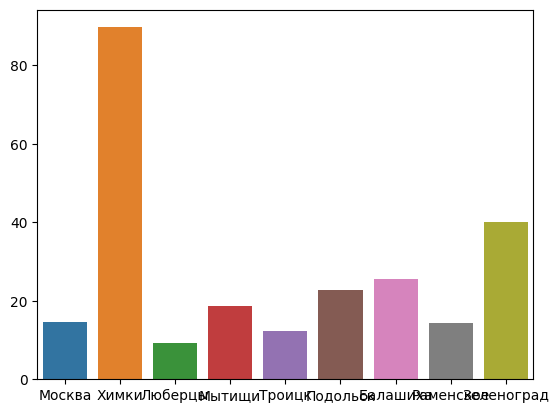

In [71]:
pd.options.mode.chained_assignment = None
dfRegion = df.dropna(subset=["Region"])
dfRegion["Region"] = dfRegion["Region"].map(lambda x: "Москва" if ("Москва" in x) else x)

# Будем рассматривать регионы, в которых есть хотя бы  объявлений
multipleOccurences = []
luxuryPercent = []
temp = {}
for i in dfRegion["Region"].unique():
    if(dfRegion.Region.value_counts()[i] > 20):
        #multipleOccurences.append(i)
        luxuryCount = dfRegion[(dfRegion["Price_range"] == "luxury") & (dfRegion["Region"] == i)].shape[0]
        totalCount = dfRegion[(dfRegion["Region"] == i)].shape[0]
        #luxuryPercent.append(luxuryCount / totalCount * 100)
        temp[i] = [luxuryCount / totalCount * 100]

#for i, j in zip(multipleOccurences, luxuryPercent):
#    print(f"{i}: {j:.3f}%")
#sns.barplot(zip(multipleOccurences, luxuryPercent))
tempDf = pd.DataFrame(temp)
sns.barplot(tempDf)

Несмотря на то, что товары роскоши составляют лишь небольшую часть от всех товаров (16.2%), их суммарная стоимость составляет около 96% - <i>гипотеза подтвердилась.</i>

<h4><b>H4. </b>Количество недорогих товаров составляет более 80% от всех товаров в датасете</h4>

Недорогие товары составляют 49.318% от всех товаров


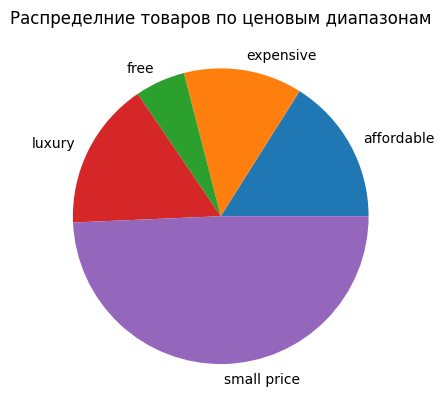

In [14]:
df.groupby("Price_range").size().plot(kind='pie', title = 'Распределние товаров по ценовым диапазонам')
count_inexpensive = df[df["Price_range"] == "small price"].shape[0]
print(f"Недорогие товары составляют {count_inexpensive / df.shape[0] * 100:.3f}% от всех товаров")

Недорогие товары (<5000 рублей) предствляют чуть меньше половины (49.32%) от всех товаров - <i>гипотеза не подтвердилась</i>

<h4><b>H5. </b>Больше всего бесплатных товаров в категории "Животные"</h4>


In [15]:
def count_free(category):
    tempDf = df[df["Category"] == category]
    count_free = tempDf[tempDf["Price_range"] == "free"].shape[0]
    return count_free/tempDf.shape[0], count_free

a = []
for cat in df['Category'].unique():
    free = count_free(cat)
    a.append((cat, free[1], free[0]))

#осортируем полученный массив по проценту бесплатных товаров в категории
a.sort(key = lambda x: x[2], reverse = True)
for i in a:
    print(f"{i[0].ljust(30)} количество: {str(i[1]).ljust(12)} процент: {i[2]*100:.3f}%")

Вакансии                       количество: 4            процент: 100.000%
Животные                       количество: 247          процент: 31.030%
Спецтехника и мотоциклы        количество: 24           процент: 24.242%
Детский гардероб               количество: 41           процент: 9.557%
Телефоны и планшеты            количество: 69           процент: 6.063%
Детские товары                 количество: 35           процент: 5.663%
Красота и здоровье             количество: 19           процент: 4.703%
Женский гардероб               количество: 37           процент: 3.260%
Легковые автомобили            количество: 57           процент: 3.083%
ТВ, аудио, видео               количество: 8            процент: 2.941%
Фото- и видеокамеры            количество: 1            процент: 2.273%
Стройматериалы и инструменты   количество: 12           процент: 2.128%
Для дома и дачи                количество: 26           процент: 2.049%
Запчасти и автотовары          количество: 1            проц

Первая строка относится к категории "Вакансии" и не является объявлением о продаже, поэтому её мы будем игнорировать.  
Видим, что в категории "Животные" бесплатных товаров больше, чем в остальных категориях как в процентном (31% от всех товаров категории), так и в абсолютном (247 объявлений) отношении - <i>гипотеза подтвердилась</i>

<h4><b>H6. </b> Средняя цена товаров в Москве выше средней цены в других регионах</h4>

<AxesSubplot: title={'center': 'Средняя цена товаров по регионам'}, xlabel='Region'>

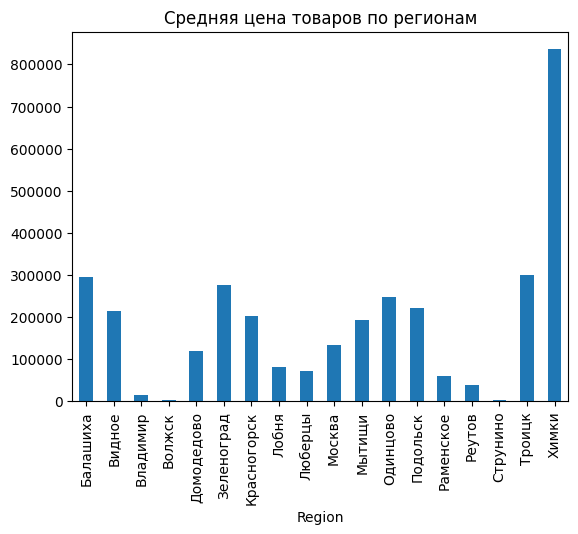

In [18]:

flags = [("Москва" in i) for i in dfRegion["Region"]]

dfRegion[dfRegion["Region"].isin(multipleOccurences)].groupby("Region")["Price"].mean().plot(kind='bar', title="Средняя цена товаров по регионам")
#dfRegion[dfRegion["Region"] == "Химки"].head(20)



<i>Гипотеза не подтвердилась</i> - есть много регионов, средняя цена товаров в которых превышает среднюю цену товаров в Москве.  
В ходе проверки данной гипотезы были получены данные, не соответствующие ожиданиям - средняя цена в определенных регионах значительно превосходит среднюю цену в столице, особенно это заметно в Химках, где средняя цена товаров и услуг составляет порядка 800000 рублей.  

Посмортим, что вызывает столь резкое отклонение средней цены в городе Химки. Для этого выведем теблицу, в которой представлены лишь товары из этого региона и установим причину.

In [21]:
dfRegion[dfRegion["Region"] == "Химки"].tail(10)

,Name,Price,Price_range,Category,Region,Placement_time,Favourites_count,Ads_count,Seller_rating,Views,Images,Link,Favourites_percent,Free_item
10161,"Ford Mondeo, 2012",575000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:24:00,3.0,177.0,NaN,9.0,14,https://youla.ru/himki/auto/s-probegom/ford-mo...,33.333333,False
10245,"Hyundai Sonata, 2019",1699000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:24:00,2.0,177.0,NaN,13.0,14,https://youla.ru/himki/auto/s-probegom/hyundai...,15.384615,False
10335,"ВАЗ (Lada) 2109, 2003",45555.0,expensive,Легковые автомобили,Химки,2023-01-14 12:00:00,23.0,1.0,NaN,849.0,5,https://youla.ru/himki/auto/s-probegom/vaz-lad...,2.709069,False
10421,"Kia Optima, 2019",950000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:25:00,1.0,177.0,NaN,30.0,14,https://youla.ru/himki/auto/s-probegom/kia-opt...,3.333333,False
10466,"Kia Cee'd, 2007",450000.0,luxury,Легковые автомобили,Химки,2023-02-01 19:24:00,0.0,178.0,NaN,22.0,7,https://youla.ru/himki/auto/s-probegom/kia-cee...,0.000000,False
10560,"Mercedes-Benz M-Класс, 2006",500000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:25:00,4.0,178.0,NaN,57.0,14,https://youla.ru/himki/auto/s-probegom/mercede...,7.017544,False
10609,"Kia Sorento, 2010",750000.0,luxury,Легковые автомобили,Химки,2023-02-01 02:23:00,1.0,178.0,NaN,157.0,13,https://youla.ru/himki/auto/s-probegom/kia-sor...,0.636943,False
10763,"Geely Coolray, 2020",850000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:26:00,2.0,176.0,NaN,18.0,14,https://youla.ru/himki/auto/s-probegom/geely-c...,11.111111,False
10805,"Kia Rio, 2010",349000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:24:00,7.0,178.0,NaN,157.0,11,https://youla.ru/himki/auto/s-probegom/kia-rio...,4.458599,False
10851,"Volkswagen Polo, 2012",435000.0,luxury,Легковые автомобили,Химки,2023-02-01 18:25:00,1.0,178.0,NaN,18.0,14,https://youla.ru/himki/auto/s-probegom/volkswa...,5.555556,False


Несложно заметить, что значительную часть товаров в данном городе составляют товары роскоши, а именно легковые автомобили